In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import torchvision as tv
import torchvision.models
from torchvision.models import resnet50, inception_v3
from skimage.io import imread
import numpy as np
from sklearn.metrics import f1_score, multilabel_confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
try:
    import onnx
except:
    %pip install onnx
    import onnx

# Create Data CSV

In [ ]:
# Define the root directory
root_dir = 'Blood_cell_Cancer'

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Iterate over subfolders
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        # Append file path
        file_path = os.path.join(subdir, file)
        file_paths.append(file_path)

        # Append label (extracted from the subfolder name)
        label = os.path.basename(subdir)
        labels.append(label)

# Create DataFrame
df = pd.DataFrame({'filename': file_paths, 'label': labels})
df.head()

,filename,label
0,Blood_cell_Cancer/[Malignant] Pre-B/Snap_004 -...,[Malignant] Pre-B
1,Blood_cell_Cancer/[Malignant] Pre-B/Snap_002.jpg,[Malignant] Pre-B
2,Blood_cell_Cancer/[Malignant] Pre-B/Snap_002 -...,[Malignant] Pre-B
3,Blood_cell_Cancer/[Malignant] Pre-B/Snap_005.jpg,[Malignant] Pre-B
4,Blood_cell_Cancer/[Malignant] Pre-B/Snap_005 -...,[Malignant] Pre-B


In [ ]:
df.info()
print()
print(df["label"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3242 entries, 0 to 3241
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  3242 non-null   object
 1   label     3242 non-null   object
dtypes: object(2)
memory usage: 50.8+ KB

label
[Malignant] early Pre-B    979
[Malignant] Pre-B          955
[Malignant] Pro-B          796
Benign                     512
Name: count, dtype: int64


In [ ]:
# One-hot encode the labels
labels_encoded = pd.get_dummies(df['label'])

# Concatenate the one-hot encoded labels DataFrame with the original DataFrame
df_one_hot = df[['filename']].join(labels_encoded)

# Display the modified DataFrame
df_one_hot.head()

,filename,Benign,[Malignant] Pre-B,[Malignant] Pro-B,[Malignant] early Pre-B
0,Blood_cell_Cancer/[Malignant] Pre-B/Snap_004 -...,False,True,False,False
1,Blood_cell_Cancer/[Malignant] Pre-B/Snap_002.jpg,False,True,False,False
2,Blood_cell_Cancer/[Malignant] Pre-B/Snap_002 -...,False,True,False,False
3,Blood_cell_Cancer/[Malignant] Pre-B/Snap_005.jpg,False,True,False,False
4,Blood_cell_Cancer/[Malignant] Pre-B/Snap_005 -...,False,True,False,False


# CustomDataset Class

The `CustomDataset` class defines a custom dataset for training a neural network model with data transformations (augmentations). The dataset is designed to load images from a DataFrame containing file paths and labels of images.

In [ ]:
# ImageNet dist
train_mean = [0.485, 0.456, 0.406]
train_std = [0.229, 0.224, 0.225]


class CustomDataset(Dataset):
    def __init__(self, data, mode):
        self.data = data  # Df containing filepaths and labels of imgs
        self.mode = mode  # training or test

        # Data transformations
        self._transform_t = tv.transforms.Compose([
            tv.transforms.ToPILImage(),
            # tv.transforms.RandomCrop((300, 300), 30, True, padding_mode='reflect'),
            # tv.transforms.ToPILImage(),
            # tv.transforms.Resize(299),
            tv.transforms.Resize((300,300)),
            tv.transforms.RandomHorizontalFlip(0.5),
            tv.transforms.RandomVerticalFlip(0.5),
            # tv.transforms.RandomRotation(360),
            # tv.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            # tv.transforms.ColorJitter(brightness=0.4, contrast=0.4),
            # tv.transforms.ColorJitter(contrast=0.4,saturation=0.4),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(train_mean, train_std),
        ])
        self._transform_v = tv.transforms.Compose([
            tv.transforms.ToPILImage(),
            tv.transforms.Resize((300,300)),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(train_mean, train_std)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        channel_last = imread(self.data.iloc[index]["filename"])
        # img = np.transpose(channel_last, (2, 0, 1))

        # load labels
        label = torch.tensor(self.data.iloc[index, 1:], dtype=torch.float32)

        # data transformations
        if self.mode == 'training':
            transformed = self._transform_t(channel_last)
        else:
            transformed = self._transform_v(channel_last)

        return transformed, label

# Custom ResNet Architecture
A small variant of the ResNet Architecture ([Paper](https://arxiv.org/abs/1512.03385)).

With the following architecture:
    
    Conv2D(3, 64, 7, 2)
    BatchNorm()
    ReLU()
    MaxPool(3, 2)
    ResBlock(64, 64, 1)
    ResBlock(64, 128, 2)
    ResBlock(128, 256, 2)
    ResBlock(256, 512, 2)
    GlobalAvgPool()
    Flatten()
    FC(512, 4)
    Softmax()


In [ ]:
class ResBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ResBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.filter_size = 3

        self.strided_conv = torch.nn.Conv2d(self.in_channels, self.out_channels, self.filter_size, self.stride, padding=(1,1))
        self.conv = torch.nn.Conv2d(self.out_channels, self.out_channels, self.filter_size, padding=(1,1))
        self.batchnorm1 = torch.nn.BatchNorm2d(self.out_channels)
        self.batchnorm2 = torch.nn.BatchNorm2d(self.out_channels)
        self.batchnorm_input = torch.nn.BatchNorm2d(self.out_channels)
        self.relu = torch.nn.ReLU()
        self.conv1x1 = torch.nn.Conv2d(self.in_channels, self.out_channels, 1, self.stride)

    def forward(self, x):
        y = self.conv1x1(x)
        y = self.batchnorm_input(y)

        x = self.strided_conv(x)
        x = self.batchnorm1(x)
        x = self.relu(x)

        x = self.conv(x)
        x = self.batchnorm2(x)

        assert y.size() == x.size(), f"shape error: input shape: {y.size()}, x shape: {x.size()}"
        return self.relu(torch.add(x, y))


class ResNet(torch.nn.Module):
    '''
    Conv2D(3, 64, 7, 2)
    BatchNorm()
    ReLU()
    MaxPool(3, 2)
    ResBlock(64, 64, 1)
    ResBlock(64, 128, 2)
    ResBlock(128, 256, 2)
    ResBlock(256, 512, 2)
    GlobalAvgPool()
    Flatten()
    FC(512, 4)
    Softmax()
    '''
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv = torch.nn.Conv2d(3, 64, 7, 2)
        self.batch_norm = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU()
        self.max_pool = torch.nn.MaxPool2d(3,2)
        self.resblocks1 = ResBlock(64,64,1)
        self.resblocks2 = ResBlock(64,128,2)
        self.resblocks3 = ResBlock(128,256,2)
        self.resblocks4 = ResBlock(256,512,2)
        self.globalavgpool = torch.nn.AdaptiveAvgPool2d((1,1))
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Linear(512,4)
        self.drop_out = torch.nn.Dropout(.2)
        self.softmax = torch.nn.Softmax(dim=1)
#         self.initialize_weights()

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.resblocks1(x)
        x = self.resblocks2(x)
        x = self.resblocks3(x)
        x = self.resblocks4(x)
        x = self.globalavgpool(x)
        # x = F.adaptive_avg_pool2d(x,(1,1))
        x = self.flatten(x)
        x = self.fc(x)
        # x = self.drop_out(x)
        return self.softmax(x)

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, torch.nn.BatchNorm2d):
                # torch.nn.init.constant_(m.weight,1)
                # torch.nn.init.constant_(m.bias,0)
                pass

# Trainer Class

The `Trainer` class is designed to facilitate training neural network models. Below is a summary of its functionalities:

## Initialization:
- `model`: The neural network model to be trained.
- `crit`: The loss function used for optimization.
- `optim`: The optimizer for updating model parameters.
- `train_dl`: Training dataset loader.
- `val_test_dl`: Validation or test dataset loader.
- `cuda`: Whether to use GPU for computation.
- `early_stopping_patience`: The number of epochs with no improvement after which training will be stopped.

## Methods:
1. `save_checkpoint`: Saves the current model state as a checkpoint.
2. `restore_best_checkpoint`: Restores the model weights from the epoch with the lowest validation loss.
3. `save_onnx`: Saves the model in ONNX format.
4. `train_step`: Performs a single training step (forward pass, backward pass, and parameter update).
5. `val_test_step`: Performs a single validation/test step (forward pass to compute loss).
6. `train_epoch`: Trains the model for one epoch and calculates training loss and accuracy.
7. `val_test`: Evaluates the model on the validation/test set and calculates loss and accuracy.
8. `metric_calc`: Calculates accuracy based on predicted labels and true labels.
9. `fit`: Trains the model for multiple epochs, optionally implementing early stopping.
10. `lr_scheduler`: Sets up a learning rate scheduler for the optimizer.



In [ ]:
class Trainer:

    def __init__(self,
                 model,  # Model to be trained.
                 crit,  # Loss function
                 optim=None,  # Optimizer
                 train_dl=None,  # Training data set
                 val_test_dl=None,  # Validation (or test) data set
                 cuda=True,  # Whether to use the GPU
                 early_stopping_patience=-1):  # The patience for early stopping
        self._model = model
        self._crit = crit
        self._optim = optim
        self._train_dl = train_dl
        self._val_test_dl = val_test_dl
        self._cuda = cuda
        self._early_stopping_patience = early_stopping_patience
        self.checkpoint = None
        self.scheduler = None

        if cuda:
            self._model = model.cuda()
            self._crit = crit.cuda()

    def save_checkpoint(self):
        '''Overwriting checkpoint whenever validation loss is improved'''
        self.checkpoint = self._model.state_dict()

    def restore_best_checkpoint(self):
        '''Restore model weights of epoch with best validation loss'''
        self._model.load_state_dict(self.checkpoint)

    def save_onnx(self, fn):
        '''Save model as .onnx-file'''
        folder_name = 'checkpoints'
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        m = self._model.cpu()
        m.eval()
        x = torch.randn(1, 3, 300, 300, requires_grad=True)
        y = self._model(x)
        torch.onnx.export(m,  # model being run
                          x,  # model input (or a tuple for multiple inputs)
                          fn,  # where to save the model (can be a file or file-like object)
                          export_params=True,  # store the trained parameter weights inside the model file
                          opset_version=10,  # the ONNX version to export the model to
                          do_constant_folding=True,  # whether to execute constant folding for optimization
                          input_names=['input'],  # the model's input names
                          output_names=['output'],  # the model's output names
                          dynamic_axes={'input': {0: 'batch_size'},  # variable lenght axes
                                        'output': {0: 'batch_size'}})

    def train_step(self, x, y):

        # Reset gradients to zero
        self._optim.zero_grad()

        # Forward pass: compute predicted y
        y_hat = self._model(x)

        # Compute loss
        loss = self._crit(y_hat, y)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Update model parameters
        self._optim.step()

        # Return loss and predicted y
        return loss, y_hat

    def val_test_step(self, x, y):

        # Forward pass: compute predicted y
        y_hat = self._model(x)

        # Compute validation loss
        loss = self._crit(y_hat, y)

        # Return validation loss and predicted y
        return loss, y_hat

    def train_epoch(self):

        # Set training mode
        self._model.train()
        total_loss = 0
        predictions = []
        targets = []

        # Iterate over batches in the training set
        for i, batch in enumerate(self._train_dl):
            imgs, labels = batch

            # Move tensors to GPU if available
            if self._cuda:
                imgs = imgs.cuda()
                labels = labels.cuda()

            loss, preds = self.train_step(imgs, labels)
            targets.extend(labels.cpu().detach().numpy())
            predictions.extend(preds.cpu().detach().numpy())
            total_loss += loss.item()

        # Calculate average batch loss
        avg_loss = total_loss / len(self._train_dl)

        # Calculate custom metric
        metric = self.metric_calc(np.array(targets), np.array(predictions))
        print(f"\tTraining Loss: {avg_loss}, Training Accuracy: {metric}")

        return avg_loss

    def val_test(self):

        # Set evaluation mode
        self._model.eval()
        total_loss = 0
        predictions = []
        targets = []

        # Disable gradient computation
        with torch.no_grad():

            # Iterate over batches in the training set
            for i, batch in enumerate(self._val_test_dl):
                imgs, labels = batch
                if self._cuda:
                    imgs = imgs.cuda()
                    labels = labels.cuda()
                loss, preds = self.val_test_step(imgs, labels)
                targets.extend(labels.cpu().detach().numpy())
                predictions.extend(preds.cpu().detach().numpy())
                total_loss += loss.item()

        # Calculate average batch loss
        avg_loss = total_loss / len(self._val_test_dl)

        # Calculate custom metric
        metric = self.metric_calc(np.array(targets), np.array(predictions))
        print(f"\t Validation Loss: {avg_loss}, Validation Accuracy: {metric}")

        return avg_loss

    def metric_calc(self, targets, predictions):
        # Convert probabilities to predicted labels
        predicted_labels = np.argmax(predictions, axis=1)

        # Compare predicted labels with true labels
        correct_predictions = np.sum(predicted_labels == np.argmax(targets, axis=1))

        # Calculate accuracy
        accuracy = correct_predictions / len(targets)

        return accuracy

    def fit(self, epochs=-1):
        assert self._early_stopping_patience > 0 or epochs > 0
        train_losses = []
        val_losses = []
        epoch = 1
        no_improvements = 0
        epoch_best = None

        # Continue training until stopping condition is met
        while True:

            # Stop by epoch number
            if epoch > epochs:
                self.restore_best_checkpoint()
                self.save_onnx('checkpoints/checkpoint_{:03d}b.onnx'.format(epoch_best))
                print(f"The lowest validation loss was achieved in epoch{epoch_best}")
                break
            print(f'Epoch: {epoch}')

            # Train the model for one epoch and record training and validation losses
            train_losses.append(float(self.train_epoch()))
            val_losses.append(float(self.val_test()))

            # Adjust learning rate using scheduler if available
            if self.scheduler:
                self.scheduler.step(val_losses[-1])

            # Save the checkpoint if validation loss is lowest
            if val_losses[-1] == min(val_losses):
                self.save_checkpoint()
                no_improvements = 0
                epoch_best = epoch
            else:
                no_improvements += 1

            # Check if early stopping condition met
            if no_improvements >= self._early_stopping_patience:
                self.restore_best_checkpoint()
                print('Early stopping.')
                self.save_onnx('checkpoints/checkpoint_{:03d}b.onnx'.format(epoch_best))
                print(f"The lowest validation loss was achieved in epoch {epoch_best}")
                break
            epoch += 1

        return train_losses, val_losses

    def lr_scheduler(self):
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self._optim, patience=5, verbose=True)

# Main Training Script

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Code is running on {device}.")

# Load the data from the DataFrame and perform a train-test-split
train, val_test = train_test_split(df_one_hot, test_size=0.3)
val, test = train_test_split(val_test, test_size=0.5)

# Set up data loading for the training, validation, and test sets
train_data = CustomDataset(train, 'training')
val_data = CustomDataset(val, 'validation')
test_data = CustomDataset(test, 'test')

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)  # No need to shuffle for test

# Create an instance of our ResNet model
model = ResNet()
print(model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0006)

trainer = Trainer(model=model,
                  crit=criterion,
                  optim=optimizer,
                  train_dl=train_loader,
                  val_test_dl=val_loader,
                  cuda=True,
                  early_stopping_patience=30)

# Call fit on trainer
epochs = 10
train_losses, val_losses = trainer.fit(epochs)

Code is running on cuda.
ResNet(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblocks1): ResBlock(
    (strided_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm_input): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv1x1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (resblocks2): ResBlock(
    (strided_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv): Conv

<ipython-input-7-df58812b2af8>:28: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert y.size() == x.size(), f"shape error: input shape: {y.size()}, x shape: {x.size()}"


The lowest validation loss was achieved in epoch9


# Plot training and validation loss

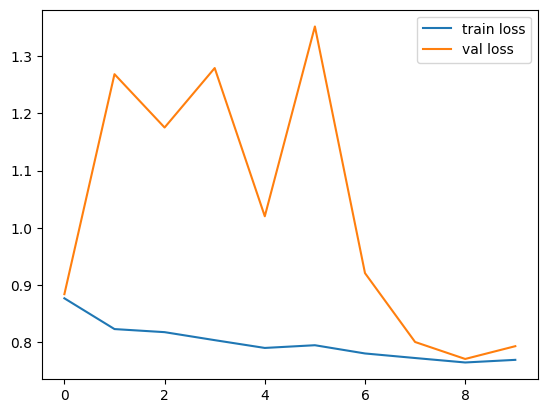

In [11]:
# Plot the training and validation losses
plt.plot(np.arange(len(train_losses)), train_losses, label='train loss')
plt.plot(np.arange(len(val_losses)), val_losses, label='val loss')
plt.legend()
plt.savefig('losses.png')

# Evaluate the model on the test set

In [12]:
# Evaluate the model on the test set
total_loss = 0.0
model.eval()
test_targets = []
test_predictions = []
with torch.no_grad():
    for inputs, targets in test_loader:
#         inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        test_targets.extend(targets.cpu().detach().numpy())
        test_predictions.extend(outputs.cpu().detach().numpy())

test_loss = total_loss /len(test_loader.dataset)
test_metric = accuracy_score(np.argmax(np.array(test_targets),axis=1), np.argmax(np.array(test_predictions), axis=1))
print(f"Test Loss: {test_loss:.6f}")
print(f"Accuracy: {test_metric:.4f}")

Test Loss: 0.025611
Accuracy: 0.9610
